# E20- Neural Networks in Keras 

Use keras framework to solve the below exercises.


In [1]:
import math
import numpy as np
import keras 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

Using TensorFlow backend.


## 20.1 Predicting Student Admissions with Neural Networks

In this notebook, we predict student admissions to graduate schools based on six pieces of data:

1. GRE Scores (Test)
2. TOEFL Scores (Test)
3. University Ranking (1-5)
4. Statement of Purpose (SOP) and Letter of Recommendation Strength ( out of 5 )
5. Undergraduate GPA Scores (Grades)
6. Research Experience ( either 0 or 1 )

**Exercise:** Design and train a shallow neural network to predict the chance of Admission for each entry. Choose the number of hidden layer and neurons that minimizes the error. 

In [2]:
# Import dataset

data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/datasets/universityGraduateAdmissions.csv', index_col=0)
data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
data.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

In [4]:
X = data.drop(data.columns[-1], axis=1)
Y = data[data.columns[-1]]

In [5]:
# Split datasets.
from sklearn.model_selection import train_test_split
X_train, X_test , Y_train, Y_test = train_test_split(X,Y, test_size=0.3 ,random_state=22)

# Normalize Data
from sklearn.preprocessing import StandardScaler

# Define the Preprocessing Method and Fit Training Data to it
scaler = StandardScaler()
scaler.fit(X)

# Make X_train to be the Scaled Version of Data
# This process scales all the values in all 6 columns and replaces them with the new values
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [6]:
print ('Total obs:',Y.shape[0])
print ('Train obs:',Y_train.shape[0])

Total obs: 500
Train obs: 350


In [7]:
# As it is a regression problem the output is a neuron.
output_var = 1
print(output_var, ' output variables')

dims = X_train.shape[1]
print(dims, 'input variables')

1  output variables
7 input variables


In [8]:
from keras import initializers
from keras import optimizers as opts
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout

from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

#!pip install livelossplot
from livelossplot import PlotLossesKeras
from keras import backend as K

### Perceptron

In [9]:
#Custom Schedule for Learning Rates:

def scheduler(epoch):
  rate=0.1
  if epoch <= 8:
    return rate
  elif epoch>8 and epoch<=40:
    return rate/10
  else:
    return rate/100

lrate2 = LearningRateScheduler(scheduler)

def step_decay(epoch):
  initial_lrate = 0.1
  drop = 0.5
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop,  
         math.floor((1+epoch)/epochs_drop))
  return lrate
  
lrate = LearningRateScheduler(step_decay)

In [10]:
#Parameters
epochs=120
#lr=0.1

#Model
K.clear_session()
print("Building model...")

print('Model variables: ', dims)

model = Sequential()
model.add(Dense(output_var, input_shape=(dims,)))

sgd= 'sgd'
op = opts.SGD(lr=0.01)
adadelta= opts.Adadelta(lr=1.0)

model.compile(loss = 'mean_squared_error',
              optimizer = op)

#Callbacks
fBestModel = 'best_model.h5' 
#,min_delta=0.000001
early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1) 
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

model.summary()

Building model...
Model variables:  7
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


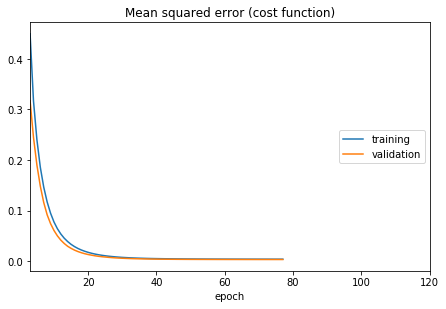

Mean squared error (cost function):
training   (min:    0.004, max:    2.416, cur:    0.004)
validation (min:    0.003, max:    0.891, cur:    0.003)
Epoch 00077: early stopping
evaluation mse: 0.0031435733184031257


In [11]:
#Fit
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs=epochs, 
          batch_size=35, verbose=True,
          callbacks=[best_model, early_stop, PlotLossesKeras()])

Y_pred=model.predict(X_test)
print('evaluation mse:',mean_squared_error(Y_test, Y_pred))

### MultiLAyer Perceptron (MLP)

In [12]:
#Parameters
epochs=120
neurons=30
#lr=0.1

#Model
K.clear_session()
print("Building model...")

print('Model variables: ', dims)

model = Sequential()
model.add(Dense(dims, input_shape=(dims,)))
model.add(Dense(dims))
model.add(Dense(output_var))
#model.add(Activation('relu'))

#Optimizers
sgd= 'sgd'
op = opts.SGD(lr=0.01)
ada= opts.Adadelta(lr=1.0)

model.compile(loss = 'mean_squared_error',
              optimizer = op)

#Callbacks
fBestModel = 'best_model.h5' 
  #,min_delta=0.000001
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

model.summary()

Building model...
Model variables:  7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


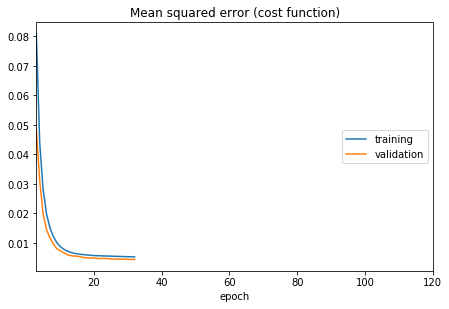

Mean squared error (cost function):
training   (min:    0.005, max:    0.717, cur:    0.005)
validation (min:    0.004, max:    0.246, cur:    0.004)
Epoch 00032: early stopping
evaluation mse: 0.004392871619738816


In [13]:
#Fit
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs=epochs, 
          batch_size=35, verbose=True,
          callbacks=[best_model, early_stop, PlotLossesKeras()])

Y_pred2=model.predict(X_test)
print('evaluation mse:',mean_squared_error(Y_test, Y_pred2))

### Deep neural Network

In [14]:
#Parameters
epochs=120
neurons=30
#lr=0.1

#Model
K.clear_session()
print("Building model...")

print('Model variables: ', dims)

model = Sequential()
model.add(Dense(dims, input_shape=(dims,)))
model.add(Dense(dims))
model.add(Dense(dims))
model.add(Dense(output_var))
#model.add(Activation('relu'))

#Optimizers
sgd= 'sgd'
op = opts.SGD(lr=0.01)
ada= opts.Adadelta(lr=1.0)

model.compile(loss = 'mean_squared_error',
              optimizer = op)

#Callbacks
fBestModel = 'best_model.h5' 
  #,min_delta=0.000001
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

model.summary()

Building model...
Model variables:  7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 8         
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


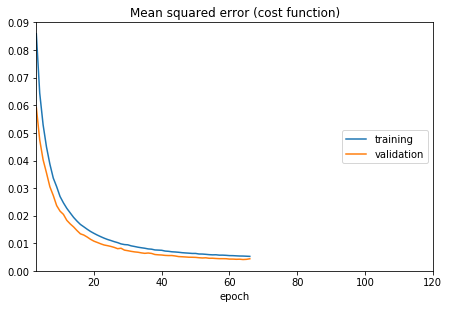

Mean squared error (cost function):
training   (min:    0.005, max:    0.635, cur:    0.005)
validation (min:    0.004, max:    0.134, cur:    0.004)
Epoch 00066: early stopping
evaluation mse: 0.004437259655989422


In [15]:
#Fit
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs=epochs, 
          batch_size=35, verbose=True,
          callbacks=[best_model, early_stop, PlotLossesKeras()])

Y_pred3=model.predict(X_test)
print('evaluation mse:',mean_squared_error(Y_test, Y_pred3))

In [16]:
Y_pred3 = Y_pred3.ravel()
results = pd.DataFrame({'y_test':Y_test,'y_pred3':Y_pred3,'error':(Y_test-Y_pred3)})
results.head()

,y_test,y_pred3,error
0,0.73,0.738090,-0.008090
1,0.92,0.907946,0.012054
2,0.70,0.649163,0.050837
3,0.76,0.675331,0.084669
4,0.86,0.853187,0.006813


### Comparing MSE of 3 models

In [17]:
from sklearn.metrics import mean_squared_error
print('model1, Perceptron, MSE=',mean_squared_error(Y_test, Y_pred))
print('model2, MultiLayer Perceptron, MSE=',mean_squared_error(Y_test, Y_pred2))
print('model3, Deep Artificial Neural Network, MSE=',mean_squared_error(Y_test, Y_pred3))

model1, Perceptron, MSE= 0.0031435733184031257
model2, MultiLayer Perceptron, MSE= 0.004392871619738816
model3, Deep Artificial Neural Network, MSE= 0.004437259655989422


## 20.2 Decision Boundary --  Moons Dataset 

**Exercise:** Use keras framework to find a decision boundary for point in the make_moons.

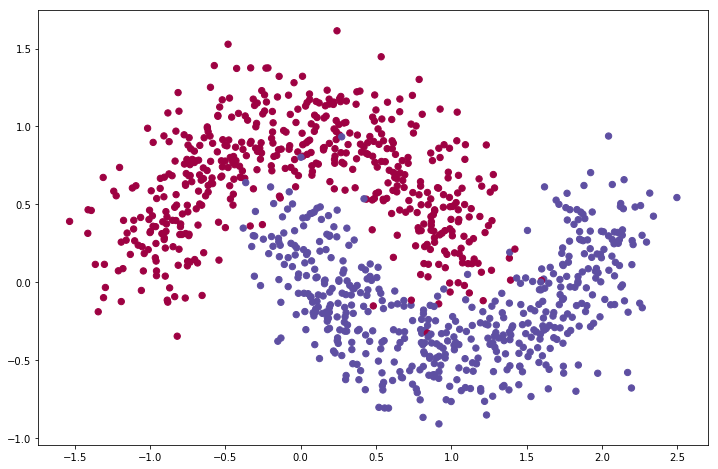

In [18]:
# Create moons dataset.

from sklearn.datasets.samples_generator import make_moons

x_train, y_train = make_moons(n_samples=1000, noise= 0.2, random_state=3)
plt.figure(figsize=(12, 8))
plt.scatter(x_train[:, 0], x_train[:,1], c=y_train, s=40, cmap=plt.cm.Spectral);

In [19]:
print (y_train.shape, x_train.shape)

(1000,) (1000, 2)


In [20]:
# Normalize Data
from sklearn.preprocessing import StandardScaler

# Define the Preprocessing Method and Fit Training Data to it
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_train

array([[ 0.05570549, -1.20540252],
       [ 0.53600402, -1.03208709],
       [ 1.53863814,  0.33780458],
       ...,
       [-0.51174207,  1.22788113],
       [-0.08050994, -1.36400898],
       [ 1.38587481, -0.70449532]])

**Hint:** Use the next function to plt the decision boundary,

In [21]:
K.clear_session()

#Parameters
epochs=100

#Model
model = Sequential()
model.add(Dense(2, input_shape=(2,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

#model = Sequential()
#model.add(Dense(2, input_shape=(2,)))
#model.add(Dense(2))
#model.add(Dense(output_var))
#model.add(Activation('sigmoid'))
#model.add(Dropout(0.5))

#Compile
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#Callbacks
fBestModel = 'best_model.h5' 
  #,min_delta=0.000001
early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1) 
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 18        
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


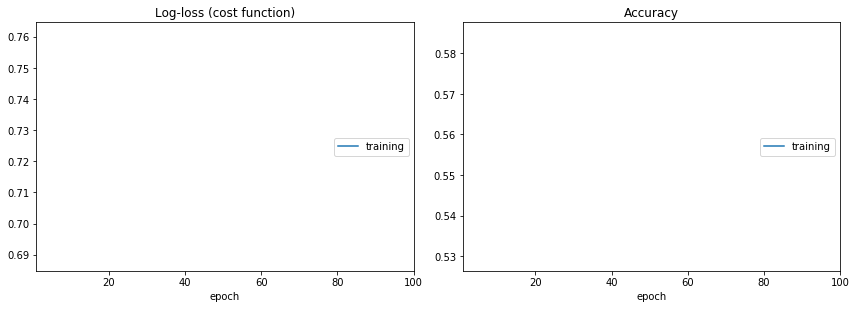

IndexError: list index out of range

In [22]:
#Fit
model.fit(x_train, y_train, epochs=epochs, 
          batch_size=100, verbose=True,
          callbacks=[best_model, early_stop, PlotLossesKeras()])

In [23]:
y_pred= model.predict(x_train)
y_pred=y_pred.ravel()
print(y_pred.shape)
y_pred =(y_pred>0.5)
y_pred[0:10]

(1000,)


array([ True,  True, False, False,  True,  True,  True,  True,  True,
        True])

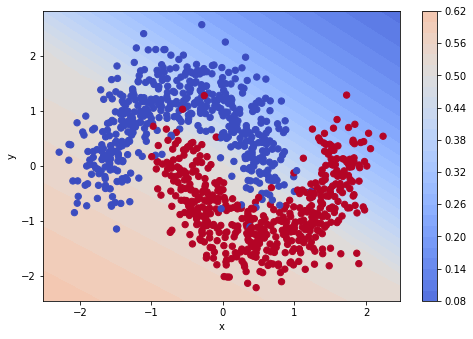

In [24]:
#model = 'Sequential neural network in keras'

def plot_decision_region(model, X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            '''
            Here 'model' is the neural network you previous trained.
            '''
            ZZ[i, j] = pred_fun(model, XX[i, j], YY[i, j])
    plt.contourf(XX, YY, ZZ, 30, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    
def pred_fun(model,x1, x2):
    '''
    Here 'model' is the neural network you previous trained.
    '''
    xval = np.array([[x1, x2]])
    return model.predict(xval)[0, 0]

plt.figure(figsize = (8,16/3))    
'''
Here 'model' is the neural network you previous trained.
'''
plot_decision_region(model, x_train, pred_fun)
#plot_data(x_train, y_train)
plt.scatter(x_train[:, 0], x_train[:,1], c=y_train, s=40, cmap=plt.cm.coolwarm);